# Relaxing an Al (1 1 1) surface under an electric field using SPHInX

If you make use of this notebook and/or its recipes, please cite the following (for which this notebook has been distributed as supporting material)

> Christoph Freysoldt, Arpit Mishra, Michael Ashton, and Jörg Neugebauer, _Generalized dipole correction for charged surfaces in the repeated-slab approach_

## Installation

You will need to install [Pyiron](https://github.com/pyiron/pyiron) and [SPHInX](https://sxrepo.mpie.de/) to run this notebook. Both are available via conda:
```
conda install -c conda-forge pyiron sphinxdft
```

If you have already installed pyiron before, check that you have the latest version:
```
conda upgrade -c conda-forge pyiron
```

Finally, please be sure to run this notebook from within your pyiron projects directory path.

In [1]:
# If you have not already configured Pyiron,
# uncomment the following lines and run this cell.

# import pyiron
# pyiron.install()

In [2]:
from pyiron import Project
import os
import numpy as np
from scipy.io.netcdf import netcdf_file
import matplotlib.pylab as plt

### Create the job

In [3]:
pr = Project("ChargedRelax")
pr.remove(enable=True)
job = pr.create_job(pr.job_type.Sphinx, "Al_111")

### Build an Al (1 1 1) surface and assign it to the job

In [4]:
job.structure = pr.create_surface("Al", "fcc111", size=[1,1,4], vacuum=10)
job.structure.add_tag(selective_dynamics=(True, True, True))
# job.structure.plot3d()  # visualize structure if nglview is installed correctly

### Freeze the bottom half of the slab

In [5]:
job.structure.selective_dynamics[
    range(len(job.structure)//2)
] = (False, False, False)

### Set up the DFT input for a basic geometry optimization

In [6]:
job.calc_minimize()

### Modify k-points for a surface calculation

In [7]:
job.set_kpoints([9, 9, 1], center_shift=[0.5, 0.5, 0.25])

### Charge the bottom layer of atoms
In this case, we are targeting a specific field on the right and left sides of the slab (`right_field` and `left_field`, respectively). The following cell calculates the charge required to create this field and then distributes this charge evenly across all "bottom" (leftmost) atoms of the slab for the initial density.

In [10]:
HARTREE_TO_EV = 27.2114
ANGSTROM_TO_BOHR = 1.8897

# atomic units (1 E_h/ea_0 ~= 51.4 V/Å)
right_field = 0.05
left_field = -0.05

cell = job.structure.cell * ANGSTROM_TO_BOHR
area = np.linalg.norm(np.cross(cell[0], cell[1]))

total_charge = (right_field - left_field) * area / (4 * np.pi) # Eqn. 3 from Freysoldt, et al.

positions = job.structure.positions
bottom_atoms = [i for i,c in enumerate(positions) if c[2] == positions[0][2]]
charged_atom_coords = positions[bottom_atoms]

charges = []
for c in charged_atom_coords:
    charges.append({
        "charge": total_charge / len(bottom_atoms),
        "coords": c
    })
job.input.sphinx.initialGuess.rho.charged = charges

### Add the dipole correction to the PAWHamiltonian group

In [11]:
job.input.sphinx.PAWHamiltonian.nExcessElectrons = -total_charge
job.input.sphinx.PAWHamiltonian.dipoleCorrection = True
job.input.sphinx.PAWHamiltonian.zField = left_field * HARTREE_TO_EV

### Run the job

In [12]:
job.run(run_again=True)

The job Al_111 was saved and received the ID: 5734655


### Plot the electrostatic potential
Uncomment the commented lines to plot the expected fields on top of the potential.

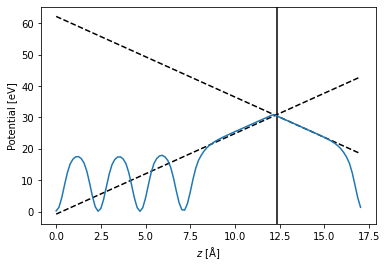

In [14]:
v_electrostatic = job.get_electrostatic_potential()
planar_avg = v_electrostatic.get_average_along_axis(2)

x = np.linspace(0, job.structure.cell[2][2], len(planar_avg))

# ind_0 = np.argwhere(x > 9)[0]
# ind_dipole = np.argmax((2 * planar_avg - np.roll(planar_avg, 1) - np.roll(planar_avg, -1))[np.abs(x - 12) < 3]) + ind_0
# m_dipole = x[ind_dipole+1]

# E_right = right_field * 51.4 * (x - m_dipole) + planar_avg[ind_dipole]
# E_left = left_field * 51.4 * (x - m_dipole) + planar_avg[ind_dipole + 1]

# plt.axvline(m_dipole, color="k")
# plt.plot(x, E_right, 'k--')
# plt.plot(x, E_left, 'k--')

plt.plot(x, planar_avg)
plt.xlabel('$z$ [Å]')
plt.ylabel('Potential [eV]')
plt.show()